In [1]:
#  Install all required libraries
!pip install lime shap imbalanced-learn xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install ipywidgets
!pip install jupyterlab_widgets



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import io
import ipywidgets as widgets
from IPython.display import display

# Create upload widget
uploader = widgets.FileUpload(accept='.csv', multiple=False)
display(uploader)

def load_data(change):
    global df
    if uploader.value:
        uploaded_file = uploader.value[0]  # because value is a tuple
        content = uploaded_file['content']
        df = pd.read_csv(io.BytesIO(content))
        print("Data loaded successfully!")
        display(df.head())  # Use display instead of print
    else:
        print("No file uploaded.")

# Attach event
uploader.observe(load_data, names='value')


FileUpload(value=(), accept='.csv', description='Upload')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Dataset shape: (5110, 12)

Missing values in each column:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Class distribution (Stroke):
stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64


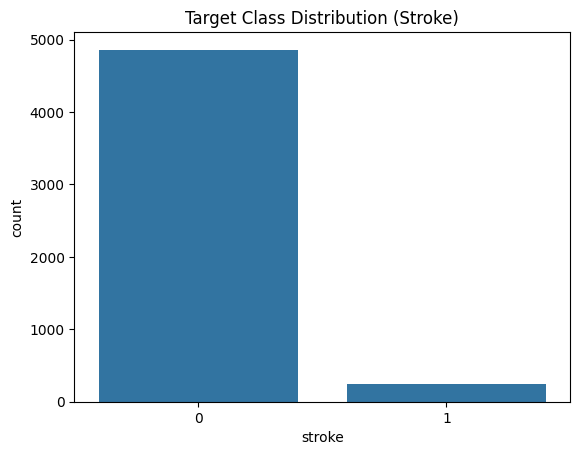

In [2]:
# 🔍 Initial Data Exploration
import seaborn as sns
import matplotlib.pyplot as plt

print("Dataset shape:", df.shape)
print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nClass distribution (Stroke):")
print(df['stroke'].value_counts(normalize=True))

# Plot target variable distribution
sns.countplot(x='stroke', data=df)
plt.title("Target Class Distribution (Stroke)")
plt.show()

In [3]:
import numpy as np

# Remove rows with "Other" gender
df = df[df['gender'] != 'Other']

# Encode binary features
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['gender'] = df['gender'].fillna(0).astype(int)

df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['ever_married'] = df['ever_married'].fillna(0).astype(int)

# Safely one-hot encode only if columns exist
dummy_cols = ['work_type', 'Residence_type', 'smoking_status']
dummy_cols = [col for col in dummy_cols if col in df.columns]

if dummy_cols:
    df = pd.get_dummies(df, columns=dummy_cols, drop_first=True, dummy_na=False)

# Drop ID column
df.drop(columns=['id'], errors='ignore', inplace=True)

# Fill missing values for all numeric columns
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

print("Data preprocessing complete!")


Data preprocessing complete!


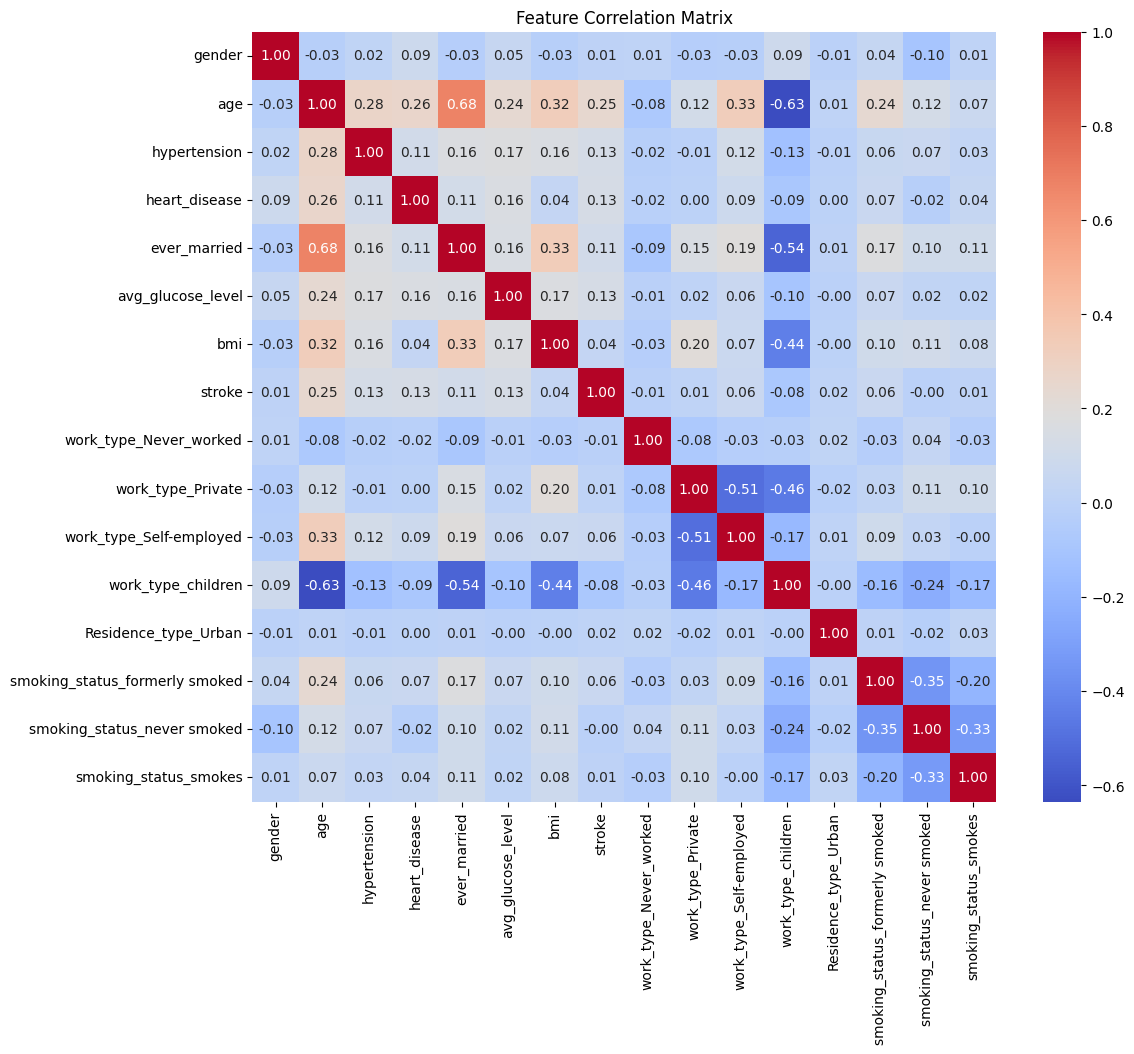

In [4]:
# 🔗 Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [5]:
# ⚖️ Train-Test Split and SMOTE
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance classes
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

print("Balanced class distribution:")
print(y_train_balanced.value_counts())

Balanced class distribution:
stroke
0    3900
1    3900
Name: count, dtype: int64


In [6]:
# 🤖 Train Multiple Models for Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True)
}

results = {}

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {"Accuracy": acc, "F1 Score": f1}
    print(f"{name} - Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))



Logistic Regression - Accuracy: 0.8493, F1 Score: 0.2376
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       960
           1       0.17      0.39      0.24        62

    accuracy                           0.85      1022
   macro avg       0.56      0.63      0.58      1022
weighted avg       0.91      0.85      0.88      1022

Random Forest - Accuracy: 0.9237, F1 Score: 0.1702
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       960
           1       0.25      0.13      0.17        62

    accuracy                           0.92      1022
   macro avg       0.60      0.55      0.57      1022
weighted avg       0.90      0.92      0.91      1022



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [16:15:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Accuracy: 0.9100, F1 Score: 0.1481
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       960
           1       0.17      0.13      0.15        62

    accuracy                           0.91      1022
   macro avg       0.56      0.54      0.55      1022
weighted avg       0.90      0.91      0.90      1022



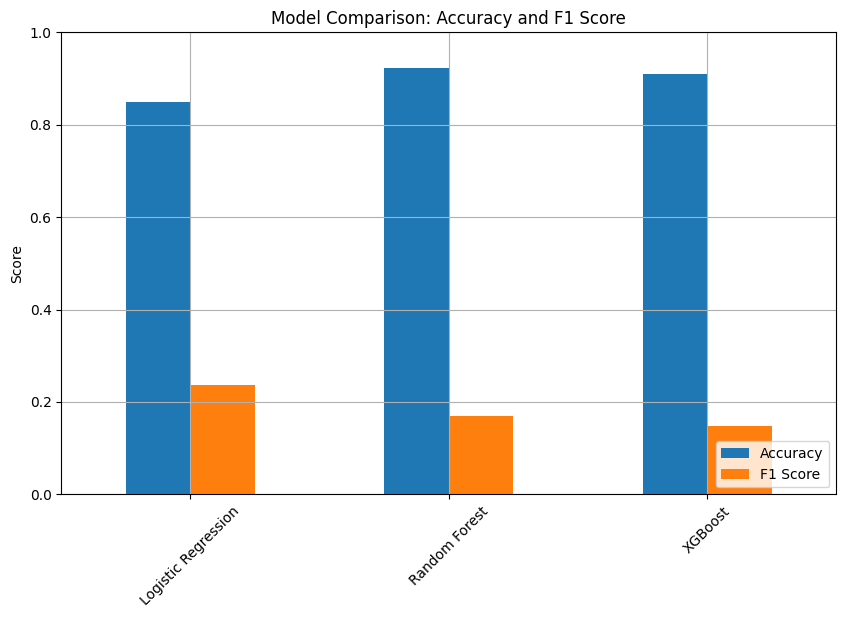

In [7]:
# 📊 Model Comparison Chart
result_df = pd.DataFrame(results).T
result_df.plot(kind='bar', figsize=(10, 6))
plt.title("Model Comparison: Accuracy and F1 Score")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [8]:
import pickle

# Train the model (assuming you already have the model ready)
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_balanced, y_train_balanced)

# Save the trained model locally
with open("stroke_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# You can now access "stroke_model.pkl" in the current working directory
print("Model saved successfully!")


Model saved successfully!


In [17]:
pip install --upgrade ipython lime


^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display, HTML
import numpy as np

# Train the model using Random Forest
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_balanced, y_train_balanced)

# Initialize Lime Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_balanced),
    feature_names=X.columns,
    class_names=['No Stroke', 'Stroke'],  # Adjust if your class names are different
    mode='classification'
)

# Explain one prediction (e.g., the first instance in the test set)
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test.iloc[i], best_model.predict_proba)

# Display the explanation in the notebook (HTML format)
html_exp = exp.as_html()
display(HTML(html_exp))


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\

In [26]:
pip install --upgrade shap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


<Figure size 640x480 with 0 Axes>

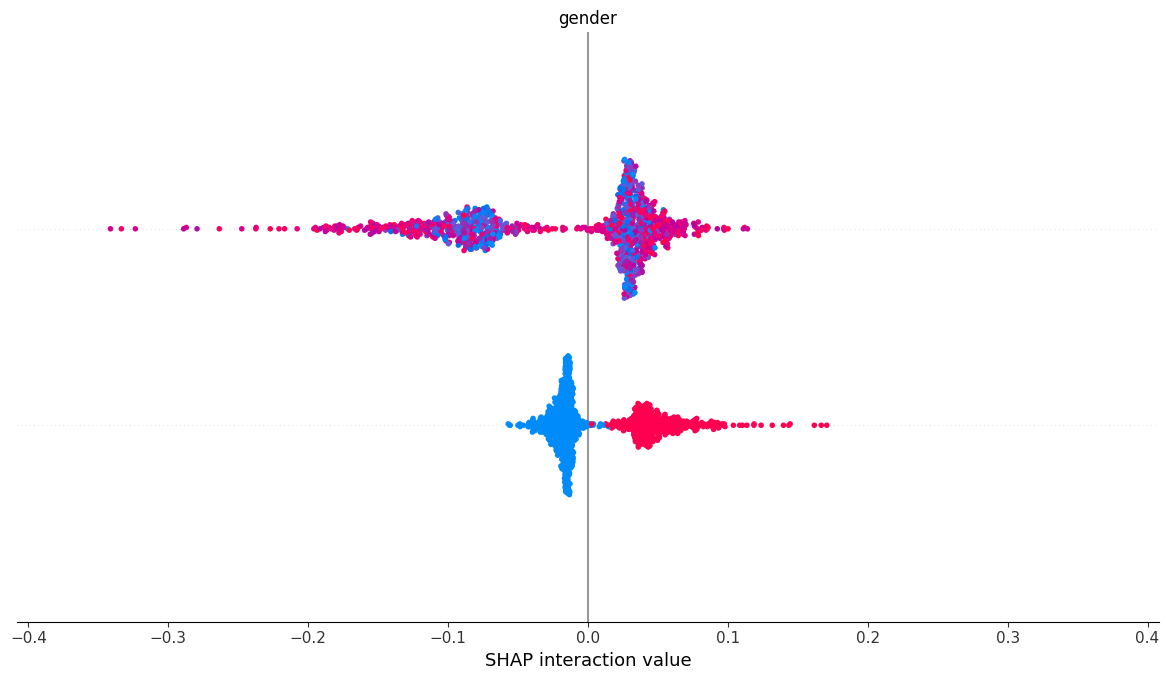

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

In [10]:
import shap

# Initialize JavaScript visualization
shap.initjs()

# Create the TreeExplainer (assuming your model is already trained)
explainer_shap = shap.TreeExplainer(best_model)

# Compute SHAP values for the test data
shap_values = explainer_shap.shap_values(X_test)

# Since it's binary classification, shap_values should not be a list
shap_values_class = shap_values  # For binary, shap_values itself is used

# Global feature importance summary
shap.summary_plot(shap_values_class, X_test)

# Local explanation for a specific instance (for example, index i = 0)
i = 0  # Index of the sample

# Ensure we pass a single instance correctly and call the force plot
shap.force_plot(
    explainer_shap.expected_value,  # For binary classification, no need to index [1]
    shap_values_class[i],  # SHAP values for the instance (just the value at index i)
    X_test.iloc[i]  # Features of the i-th instance
)


# import shap

# # Initialize JavaScript visualization
# shap.initjs()

# # Create the TreeExplainer (assuming your model is already trained)
# explainer_shap = shap.TreeExplainer(best_model)

# # Compute SHAP values for the test data
# shap_values = explainer_shap.shap_values(X_test)

# # Since it's binary classification, shap_values should not be a list
# shap_values_class = shap_values  # For binary, shap_values itself is used

# # Global feature importance summary
# shap.summary_plot(shap_values_class, X_test)

# # Local explanation for a specific instance (for example, index i = 0)
# i = 0  # Index of the sample

# # Ensure we pass the correct base value, SHAP values, and features for the force plot
# shap.plots.force(
#     explainer_shap.expected_value,  # Base value (the model's expected output)
#     shap_values_class[i],  # SHAP values for the instance (just the value at index i)
#     X_test.iloc[i]  # Features of the i-th instance
# )


In [ ]:
import pickle

with open("stroke_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:

print(X_test.shape)
print(y_test.shape)


(1022, 15)
(1022,)


In [15]:
# Predict on the X_test data
y_pred = loaded_model.predict(X_test)

print("First 10 Predictions:", y_pred[:10])

print("First 10 Actual Labels:", y_test[:10].values)

print("Predictions done successfully!")


First 10 Predictions: [0 0 0 0 0 0 0 0 0 0]
First 10 Actual Labels: [0 0 0 0 0 0 0 0 0 0]
Predictions done successfully!


In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
cr = classification_report(y_test, y_pred)
print("Classification Report:\n", cr)


Accuracy: 0.9237
Confusion Matrix:
 [[936  24]
 [ 54   8]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       960
           1       0.25      0.13      0.17        62

    accuracy                           0.92      1022
   macro avg       0.60      0.55      0.57      1022
weighted avg       0.90      0.92      0.91      1022

